# Data Preparation

In [175]:
import pydicom
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import pylab

from scipy import ndimage
from skimage import morphology

import pandas as pd
import os

%matplotlib inline

from skimage.io import imread, imshow
from skimage.transform import resize

# Don't Show Warning Messages
import warnings
warnings.filterwarnings('ignore')

In [176]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image

In [177]:
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

In [178]:
def remove_noise(file_path, num1, num2, display=False):
    medical_image = pydicom.read_file(file_path)
    image = medical_image.pixel_array
    
    hu_image = transform_to_hu(medical_image, image)
    brain_image = window_image(hu_image, 40, 80)

    # morphology.dilation creates a segmentation of the image
    # If one pixel is between the origin and the edge of a square of size
    # 5x5, the pixel belongs to the same class
    
    # We can instead use a circule using: morphology.disk(2)
    # In this case the pixel belongs to the same class if it's between the origin
    # and the radius
    
    segmentation = morphology.dilation(brain_image, np.ones((1, 1)))
    labels, label_nb = ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(np.int))
    # The size of label_count is the number of classes/segmentations found
    
    # We don't use the first class since it's the background
    label_count[0] = 0
    
    # We create a mask with the class with more pixels
    # In this case should be the brain
    mask = labels == label_count.argmax()
    
    # Improve the brain mask
    mask = morphology.dilation(mask, np.ones((1, 1)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))
    
    # Since the the pixels in the mask are zero's and one's
    # We can multiple the original image to only keep the brain region
    masked_image = mask * brain_image
    
    brain_image2 = window_image(hu_image, num1, num2)
    masked_imageWndwd = mask * brain_image2

    if display:
        plt.figure(figsize=(15, 2.5))
        plt.subplot(141)
        plt.imshow(brain_image)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(142)
        plt.imshow(mask)
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(143)
        plt.imshow(masked_image)
        plt.title('Final Image')
        plt.axis('off')
    
    return masked_imageWndwd

In [179]:
def RGB(pencere_tipi):    
    img_2d = pencere_tipi.astype(float)
    ## Step 2. Rescaling grey scale between 0-255
    img_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0
    ## Step 3. Convert to uint
    img_2d_scaled = np.uint8(img_2d_scaled)

    return img_2d_scaled

## Show images

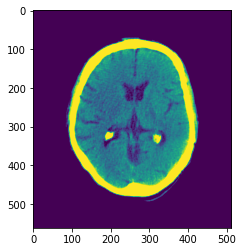

In [180]:
dicomFile = "/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/ISKEMI/11417.dcm"

final_image = remove_noise(dicomFile,40,80, display=False)

plt.imshow(final_image)

In [181]:
print('Shape: ', final_image.shape)
print('Max pixel value: ', final_image.max())
print('Min pixel value: ', final_image.min())

Shape:  (562, 512)
Max pixel value:  80.0
Min pixel value:  0.0


In [182]:
final_image.shape[0]

562

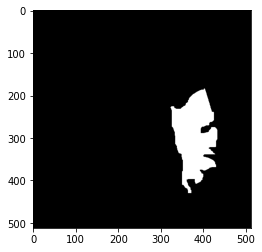

In [183]:
sample_mask = '/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/ISKEMI/MASK/10105.png'

# read the mask using skimage
mask = imread(sample_mask)

plt.imshow(mask, cmap='gray')

In [184]:
print('Shape: ', mask.shape)
print('Max pixel value: ', mask.max())
print('Min pixel value: ', mask.min())

Shape:  (512, 512)
Max pixel value:  1
Min pixel value:  0


## Create File Lists

In [185]:
images_paths = os.listdir("/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/ISKEMI/")
masks_paths = os.listdir("/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/ISKEMI/MASK/")

In [186]:
images_paths2 = os.listdir("/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/KANAMA/")
masks_paths2 = os.listdir("/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/KANAMA/MASK/")

In [187]:
len(images_paths), len(masks_paths)

(1130, 1130)

In [188]:
len(images_paths2), len(masks_paths2)

(1091, 1091)

In [189]:
images_paths.sort()
images_paths2.sort()
masks_paths.sort()
masks_paths2.sort()

# RGB icin 3 farkli pencereleme olusturmak

In [190]:
KemikPenceresi = []
IskemiPenceresi = []
KanamaPenceresi = []

## Iskemi

**Bone Windowing**

In [191]:
x=0
cnt=0

for dcmFile in images_paths:
    
    dicomFile = '/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/ISKEMI/' + dcmFile
        
    #print(dcmFile)

    final_image = remove_noise(dicomFile ,40 , 380, display=False)
    
    if final_image.shape[0] != 512:
        src = final_image
        # set a new height in pixels
        new_height = 512
        # dsize
        dsize = (src.shape[1], new_height)
        # resize image
        final_image = cv2.resize(src, dsize, interpolation = cv2.INTER_AREA)
        #plt.imshow(output)
        #print('SHAPE 1 FARKLI')
        cnt+=1

    
    if final_image.shape[1] != 512:
        src = final_image
        # set a new width in pixels
        new_width = 512
        # dsize
        dsize = (new_width, src.shape[0])
        # resize image
        final_image = cv2.resize(src, dsize, interpolation = cv2.INTER_AREA)
        #print('SHAPE 2 FARKLI')
        #plt.imshow(output)
        
    KemikPenceresi.append(final_image)
    
    x+=1

    #print("***"+str(x)+"***")
    

**Iskemi Windowing**

In [192]:
x=0
cnt=0

for dcmFile in images_paths:
    
    dicomFile = '/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/ISKEMI/' + dcmFile
        
    #print(dcmFile)

    final_image = remove_noise(dicomFile ,32 ,8 , display=False)
    
    if final_image.shape[0] != 512:
        src = final_image
        # set a new height in pixels
        new_height = 512
        # dsize
        dsize = (src.shape[1], new_height)
        # resize image
        final_image = cv2.resize(src, dsize, interpolation = cv2.INTER_AREA)
        #plt.imshow(output)
        #print('SHAPE 1 FARKLI')
        cnt+=1

    
    if final_image.shape[1] != 512:
        src = final_image
        # set a new width in pixels
        new_width = 512
        # dsize
        dsize = (new_width, src.shape[0])
        # resize image
        final_image = cv2.resize(src, dsize, interpolation = cv2.INTER_AREA)
        #print('SHAPE 2 FARKLI')
        #plt.imshow(output)
    
    IskemiPenceresi.append(final_image)

    x+=1

    #print("***"+str(x)+"***")
    

**Kanama Windowing**

In [193]:
x=0
cnt=0

for dcmFile in images_paths:
    
    dicomFile = '/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/ISKEMI/' + dcmFile
        
    #print(dcmFile)

    final_image = remove_noise(dicomFile ,80 ,150 , display=False)
    
    if final_image.shape[0] != 512:
        src = final_image
        # set a new height in pixels
        new_height = 512
        # dsize
        dsize = (src.shape[1], new_height)
        # resize image
        final_image = cv2.resize(src, dsize, interpolation = cv2.INTER_AREA)
        #plt.imshow(output)
        #print('SHAPE 1 FARKLI')
        cnt+=1

    
    if final_image.shape[1] != 512:
        src = final_image
        # set a new width in pixels
        new_width = 512
        # dsize
        dsize = (new_width, src.shape[0])
        # resize image
        final_image = cv2.resize(src, dsize, interpolation = cv2.INTER_AREA)
        #print('SHAPE 2 FARKLI')
        #plt.imshow(output)
    
    KanamaPenceresi.append(final_image)

    x+=1

    #print("***"+str(x)+"***")
    

In [194]:
print(len(KemikPenceresi))
print(len(IskemiPenceresi))
print(len(KanamaPenceresi))

1130
1130
1130


In [195]:
IskemiButunPencereler=[]
IskemiButunPencereler.append(KemikPenceresi)
IskemiButunPencereler.append(IskemiPenceresi)
IskemiButunPencereler.append(KanamaPenceresi)

In [196]:
len(IskemiButunPencereler)

3

(-0.5, 511.5, 511.5, -0.5)

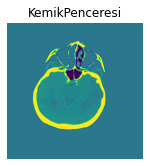

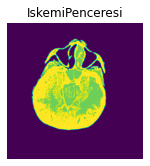

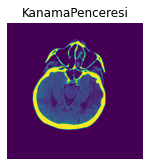

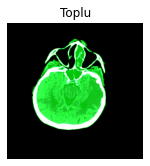

In [197]:
toplu = cv2.merge([RGB(KemikPenceresi[2]), RGB(IskemiPenceresi[2]), RGB(KanamaPenceresi[2])])

plt.figure(figsize=(15, 2.5))
plt.subplot(141)
plt.imshow(KemikPenceresi[2])
plt.title('KemikPenceresi')
plt.axis('off')

plt.figure(figsize=(15, 2.5))
plt.subplot(142)
plt.imshow(IskemiPenceresi[2])
plt.title('IskemiPenceresi')
plt.axis('off')

plt.figure(figsize=(15, 2.5))
plt.subplot(143)
plt.imshow(KanamaPenceresi[2])
plt.title('KanamaPenceresi')
plt.axis('off')

plt.figure(figsize=(15, 2.5))
plt.subplot(144)
plt.imshow(toplu)
plt.title('Toplu')
plt.axis('off')



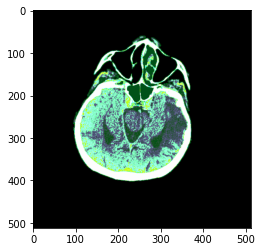

In [198]:
plt.imshow(toplu*3)

## Kanama

In [199]:
KemikPenceresi = []
IskemiPenceresi = []
KanamaPenceresi = []

**Bone Windowing**

In [200]:
x=0
cnt=0

for dcmFile in images_paths2:
    
    dicomFile = '/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/KANAMA/' + dcmFile
        
    #print(dcmFile)

    final_image = remove_noise(dicomFile ,40 , 380, display=False)
    
    if final_image.shape[0] != 512:
        src = final_image
        # set a new height in pixels
        new_height = 512
        # dsize
        dsize = (src.shape[1], new_height)
        # resize image
        final_image = cv2.resize(src, dsize, interpolation = cv2.INTER_AREA)
        #plt.imshow(output)
        #print('SHAPE 1 FARKLI')
        cnt+=1

    
    if final_image.shape[1] != 512:
        src = final_image
        # set a new width in pixels
        new_width = 512
        # dsize
        dsize = (new_width, src.shape[0])
        # resize image
        final_image = cv2.resize(src, dsize, interpolation = cv2.INTER_AREA)
        #print('SHAPE 2 FARKLI')
        #plt.imshow(output)
    
    KemikPenceresi.append(final_image)
    
    x+=1

    #print("***"+str(x)+"***")
    

In [201]:
print(len(KemikPenceresi))

1091


**Iskemi Windowing**

In [202]:
x=0
cnt=0

for dcmFile in images_paths2:
    
    dicomFile = '/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/KANAMA/' + dcmFile
        
    #print(dcmFile)

    final_image = remove_noise(dicomFile ,32 ,8 , display=False)
    
    if final_image.shape[0] != 512:
        src = final_image
        # set a new height in pixels
        new_height = 512
        # dsize
        dsize = (src.shape[1], new_height)
        # resize image
        final_image = cv2.resize(src, dsize, interpolation = cv2.INTER_AREA)
        #plt.imshow(output)
        #print('SHAPE 1 FARKLI')
        cnt+=1

    
    if final_image.shape[1] != 512:
        src = final_image
        # set a new width in pixels
        new_width = 512
        # dsize
        dsize = (new_width, src.shape[0])
        # resize image
        final_image = cv2.resize(src, dsize, interpolation = cv2.INTER_AREA)
        #print('SHAPE 2 FARKLI')
        #plt.imshow(output)

    IskemiPenceresi.append(final_image)
        
    x+=1

    #print("***"+str(x)+"***")
    

**Kanama Windowing**

In [203]:
x=0
cnt=0

for dcmFile in images_paths2:
    
    dicomFile = '/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/KANAMA/' + dcmFile
        
    #print(dcmFile)

    final_image = remove_noise(dicomFile ,80 ,150 , display=False)
    
    if final_image.shape[0] != 512:
        src = final_image
        # set a new height in pixels
        new_height = 512
        # dsize
        dsize = (src.shape[1], new_height)
        # resize image
        final_image = cv2.resize(src, dsize, interpolation = cv2.INTER_AREA)
        #plt.imshow(output)
        #print('SHAPE 1 FARKLI')
        cnt+=1

    
    if final_image.shape[1] != 512:
        src = final_image
        # set a new width in pixels
        new_width = 512
        # dsize
        dsize = (new_width, src.shape[0])
        # resize image
        final_image = cv2.resize(src, dsize, interpolation = cv2.INTER_AREA)
        #print('SHAPE 2 FARKLI')
        #plt.imshow(output)

    KanamaPenceresi.append(final_image)
        
    x+=1

    #print("***"+str(x)+"***")
    

In [204]:
print(len(KemikPenceresi))
print(len(IskemiPenceresi))
print(len(KanamaPenceresi))

1091
1091
1091


In [205]:
KanamaButunPencereler=[]
KanamaButunPencereler.append(KemikPenceresi)
KanamaButunPencereler.append(IskemiPenceresi)
KanamaButunPencereler.append(KanamaPenceresi)

(-0.5, 511.5, 511.5, -0.5)

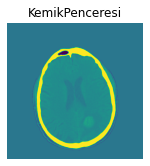

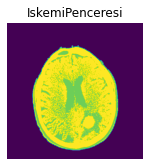

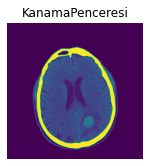

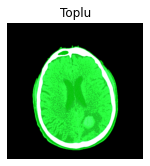

In [206]:
toplu = cv2.merge([RGB(KemikPenceresi[2]), RGB(IskemiPenceresi[2]), RGB(KanamaPenceresi[2])])

plt.figure(figsize=(15, 2.5))
plt.subplot(141)
plt.imshow(KemikPenceresi[2])
plt.title('KemikPenceresi')
plt.axis('off')

plt.figure(figsize=(15, 2.5))
plt.subplot(142)
plt.imshow(IskemiPenceresi[2])
plt.title('IskemiPenceresi')
plt.axis('off')

plt.figure(figsize=(15, 2.5))
plt.subplot(143)
plt.imshow(KanamaPenceresi[2])
plt.title('KanamaPenceresi')
plt.axis('off')

plt.figure(figsize=(15, 2.5))
plt.subplot(144)
plt.imshow(toplu)
plt.title('Toplu')
plt.axis('off')


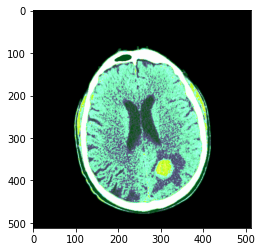

In [207]:
plt.imshow(toplu*3)

# Merging All Windows into 1(RGB) Image

In [208]:
MergedIskemiImages = []
MergedKanamaImages = []

In [209]:
print(len(IskemiButunPencereler[0]))
print(len(IskemiButunPencereler[1]))
print(len(IskemiButunPencereler[2]))

1130
1130
1130


In [210]:
x=0
  
for indexImages in range (0,len(IskemiButunPencereler[0])):
    
    #print(indexImages)

    KemikImage = IskemiButunPencereler[0][indexImages]
    IskemiImage = IskemiButunPencereler[1][indexImages]
    KanamaImage = IskemiButunPencereler[2][indexImages]

    Toplu = cv2.merge([RGB(KemikImage), RGB(IskemiImage), RGB(KanamaImage)])
    
    MergedIskemiImages.append(Toplu*3)

    x+=1

    #print("***"+str(x)+"***")



In [211]:
print(len(KanamaButunPencereler[0]))
print(len(KanamaButunPencereler[1]))
print(len(KanamaButunPencereler[2]))

1091
1091
1091


In [212]:
x=0
  
for indexImages in range (0,len(KanamaButunPencereler[0])):
    
    #print(indexImages)

    KemikImage = KanamaButunPencereler[0][indexImages]
    IskemiImage = KanamaButunPencereler[1][indexImages]
    KanamaImage = KanamaButunPencereler[2][indexImages]

    Toplu = cv2.merge([RGB(KemikImage), RGB(IskemiImage), RGB(KanamaImage)])
    
    MergedKanamaImages.append(Toplu*3)

    x+=1

    #print("***"+str(x)+"***")



In [213]:
print(len(MergedIskemiImages))
print(len(MergedKanamaImages))

1130
1091


## Create X-train Y-train X-test Y-test

In [214]:
val_size = int(len(MergedIskemiImages) * .20)
val_size

226

In [215]:
X_trainIskemi = MergedIskemiImages[val_size:]
X_testIskemi = MergedIskemiImages[:val_size]
Y_trainIskemi = masks_paths[val_size:]  # Burada Onemli birsey var!!! Ayni mi acaba maskeler?
Y_testIskemi = masks_paths[:val_size]

In [216]:
len(X_trainIskemi), len(X_testIskemi), len(Y_trainIskemi), len(Y_testIskemi)

(904, 226, 904, 226)

In [217]:
val_size2 = int(len(MergedKanamaImages) * .20)
val_size2

218

In [218]:
X_trainKanama = MergedKanamaImages[val_size2:]
X_testKanama = MergedKanamaImages[:val_size2]
Y_trainKanama = masks_paths2[val_size2:]  # Burada Onemli birsey var!!! Ayni mi acaba maskeler?
Y_testKanama = masks_paths2[:val_size2]

In [219]:
len(X_trainKanama), len(X_testKanama), len(Y_trainKanama), len(Y_testKanama)

(873, 218, 873, 218)

In [220]:
MainX_train = X_trainIskemi + X_trainKanama
MainX_test = X_testIskemi + X_testKanama
MainY_train = Y_trainIskemi + Y_trainKanama
MainY_test = Y_testIskemi + Y_testKanama

## Testing to See Images are in same order

### Train

11377.png


(-0.5, 511.5, 511.5, -0.5)

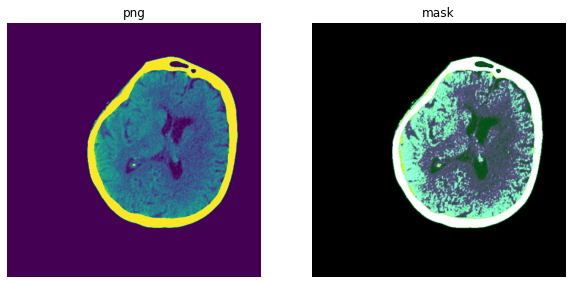

In [221]:
print(MainY_train[0])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 15), sharex=True, sharey=True)
dicomFile = "/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/ISKEMI/11377.dcm"
final_image = remove_noise(dicomFile,40,80, display=False)
ax1.imshow(final_image)
ax1.set_title('png')
ax1.axis('off')

ax2.imshow(MainX_train[0])
ax2.set_title('mask')
ax2.axis('off')

13290.png


(-0.5, 511.5, 511.5, -0.5)

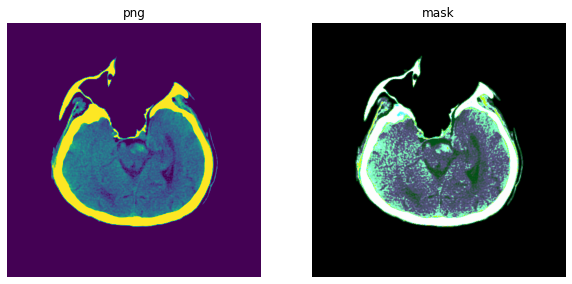

In [222]:
print(MainY_train[1203])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 15), sharex=True, sharey=True)
dicomFile = "/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/KANAMA/13290.dcm"
final_image = remove_noise(dicomFile,40,80, display=False)
ax1.imshow(final_image)
ax1.set_title('png')
ax1.axis('off')

ax2.imshow(MainX_train[1203])
ax2.set_title('mask')
ax2.axis('off')

16973.png


(-0.5, 511.5, 511.5, -0.5)

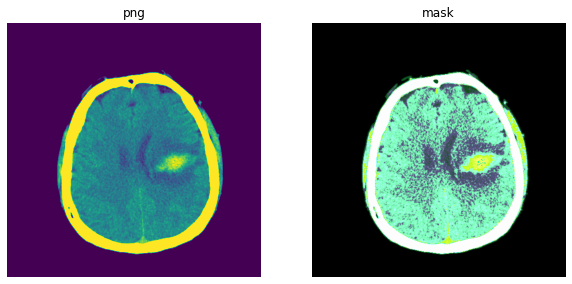

In [223]:
print(MainY_train[1768])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 15), sharex=True, sharey=True)
dicomFile = "/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/KANAMA/16973.dcm"
final_image = remove_noise(dicomFile,40,80, display=False)
ax1.imshow(final_image)
ax1.set_title('png')
ax1.axis('off')

ax2.imshow(MainX_train[1768])
ax2.set_title('mask')
ax2.axis('off')

### Test

11377.png


(-0.5, 511.5, 511.5, -0.5)

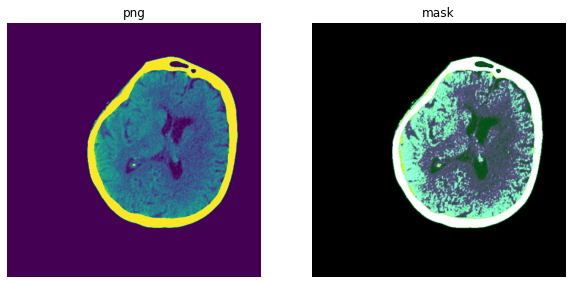

In [224]:
print(MainY_train[0])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 15), sharex=True, sharey=True)
dicomFile = "/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/ISKEMI/11377.dcm"
final_image = remove_noise(dicomFile,40,80, display=False)
ax1.imshow(final_image)
ax1.set_title('png')
ax1.axis('off')

ax2.imshow(MainX_train[0])
ax2.set_title('mask')
ax2.axis('off')

14051.png


(-0.5, 511.5, 511.5, -0.5)

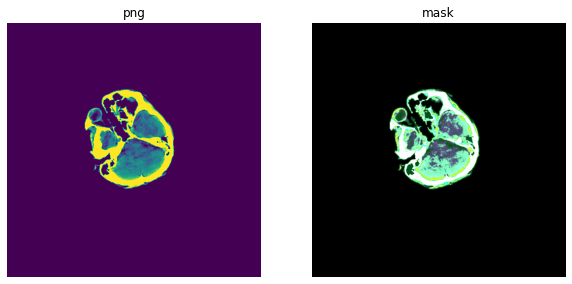

In [225]:
print(MainY_train[400])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 15), sharex=True, sharey=True)
dicomFile = "/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/ISKEMI/14051.dcm"
final_image = remove_noise(dicomFile,40,80, display=False)
ax1.imshow(final_image)
ax1.set_title('png')
ax1.axis('off')

ax2.imshow(MainX_train[400])
ax2.set_title('mask')
ax2.axis('off')

15241.png


(-0.5, 511.5, 511.5, -0.5)

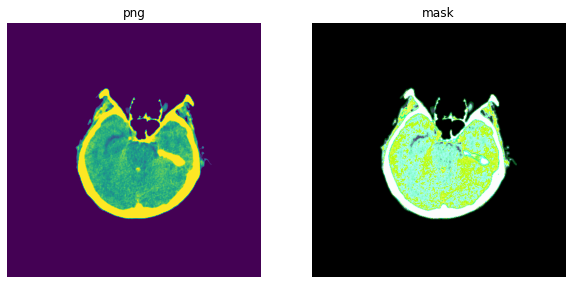

In [226]:
print(MainY_train[1500])

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 15), sharex=True, sharey=True)
dicomFile = "/Users/esmasert/Desktop/TeknoFest/Veriler/DataSegmentation/KANAMA/15241.dcm"
final_image = remove_noise(dicomFile,40,80, display=False)
ax1.imshow(final_image)
ax1.set_title('png')
ax1.axis('off')

ax2.imshow(MainX_train[1500])
ax2.set_title('mask')
ax2.axis('off')

**They seems to be in the same order**

## Image Lists olarak Y-train ve Y-test'leri olusturma

**Zaten training olarak image listleri olusturmustuk, bu yuzden sadece maskelerin image listini create yapacagiz**

In [227]:
IMG_HEIGHT = 512
IMG_WIDTH = 512
IMG_CHANNELS = 1

In [228]:
# Get lists of masks.
mask_id_list = MainY_train
testMask_id_list = MainY_test

# Create empty arrays
Y_train = np.zeros((len(mask_id_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
Y_test = np.zeros((len(testMask_id_list), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

In [229]:
X_train = MainX_train
X_test = MainX_test

In [230]:
len(X_train), len(Y_train), len(X_test), len(Y_test)

(1777, 1777, 444, 444)

In [231]:
import numpy as np
X_train = np.array(X_train)
X_test = np.array(X_test)

In [232]:
# Y_train

for i, mask_id in enumerate(mask_id_list):
    
    try:
        path_mask = '/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/ISKEMI/MASK/' + mask_id
        f = open(path_mask)
        flag=1
    except IOError:
        #print("File not accessible")
        flag=2
    finally:
        f.close()
    
    
    if flag == 1:
        path_mask = '/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/ISKEMI/MASK/' + mask_id
    elif flag == 2:
        path_mask = '/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/KANAMA/MASK/' + mask_id
    
    #print(mask_id)
    #print(i)
        
    # read the image using skimage
    mask = imread(path_mask)
    
    #print(mask.shape)
    
    if mask.shape[0] != 512:
        #print('ESIT DEGILL')
    
    # resize the image
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    #print(mask.shape)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    mask = np.expand_dims(mask, axis=-1)
    
    # insert the image into Y_Train
    Y_train[i] = mask

Y_train.shape

IndentationError: expected an indented block (<ipython-input-232-870207353a6f>, line 33)

In [ ]:
# Y_test

for i, mask_id in enumerate(testMask_id_list):
    
    try:
        path_mask = '/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/ISKEMI/MASK/' + mask_id
        f = open(path_mask)
        flag=1
    except IOError:
        #print("File not accessible")
        flag=2
    finally:
        f.close()
    
    if flag == 1:
        path_mask = '/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/ISKEMI/MASK/' + mask_id
    elif flag == 2:
        path_mask = '/Users/esmasert/Desktop/TeknoFest/Veriler/Maskeler/TRAINING/KANAMA/MASK/' + mask_id
    
    #print(mask_id)
    #print(i)
        
    # read the image using skimage
    mask = imread(path_mask)
    
    # resize the image
    mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    
    # use np.expand dims to add a channel axis so the shape becomes (IMG_HEIGHT, IMG_WIDTH, 1)
    mask = np.expand_dims(mask, axis=-1)
    
    # insert the image into Y_Train
    Y_test[i] = mask

Y_test.shape

In [129]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1777, 512, 512, 3)
(1777, 512, 512, 1)
(444, 512, 512, 3)
(444, 512, 512, 1)


# Model

## Model Architecture

In [130]:
kucukX_train = X_train[:100]
kucukY_train = Y_train[:100]

kucukX_test = X_test[:10]
kucukY_test = Y_test[:10]

In [131]:
kucukY_train.shape

(100, 512, 512, 1)

In [132]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import layers
from tensorflow.python.keras.utils.data_utils import Sequence

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

from keras.preprocessing import image

from sklearn.model_selection import train_test_split

from skimage.transform import resize

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import shutil
import PIL
import pathlib
import pandas as pd
import cv2
from imgaug import augmenters as iaa
import imgaug as ia

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import itertools

import re

In [133]:
def downstream_block(layer, number_filters):
    layer = layers.Conv2D(number_filters, 3, activation='relu', padding="same")(layer)
    cropped_feature_map = layers.Conv2D(number_filters, 3, activation='relu', padding="same")(layer)
    layer = layers.MaxPool2D(2, strides=2, padding='same')(cropped_feature_map)

    return layer, cropped_feature_map

In [134]:
def upstream_block(layer, number_filters, cropped_feature_map):
    layer = layers.Conv2DTranspose(number_filters, (2, 2), strides=(2, 2), padding='same')(layer)
    layer = layers.concatenate([layer, cropped_feature_map])
    layer = layers.Conv2D(number_filters, 3, activation='relu', padding="same")(layer)
    layer = layers.Conv2D(number_filters, 3, activation='relu', padding="same")(layer)

    return layer

In [159]:
def u_net():
    input = layers.Input(input_shape)
    layer = input

    cropped_feature_maps = []

    for index in range(steps + 1):
        current_number_filters = number_filters * 2 ** index
        layer, cropped_feature_map = downstream_block(layer, current_number_filters)
        cropped_feature_maps.append(cropped_feature_map)

    layer = cropped_feature_maps.pop()

    for index in range(steps - 1, -1, -1):
        current_number_filters = number_filters * 2 ** index
        layer = upstream_block(layer, current_number_filters, cropped_feature_maps[index])

    output = layers.Conv2D(number_classes, 1, activation='sigmoid')(layer)
    model = Model(input, output)

    return model

In [160]:
input_shape = (512, 512, 3)
img_size = 512
number_filters = 16 
steps = 4
number_classes = 1

In [161]:
model = None
model = u_net()

In [162]:
batch_size = 32

learning_rate = 3e-4
epochs = 2

In [163]:
def polynomial_decay(epoch):
    power = 1.0

    alpha = learning_rate * (1 - (epoch / float(epochs))) ** power
    return alpha

In [164]:
filepath="/Users/esmasert/Desktop/modelss/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, 
                                save_weights_only=True, mode='max', period=1)



lr_decay = LearningRateScheduler(polynomial_decay)

In [165]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 512, 512, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 512, 512, 16) 2320        conv2d_38[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 256, 256, 16) 0           conv2d_39[0][0]                  
____________________________________________________________________________________________

In [166]:
model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=['acc'])

In [167]:
train_steps = int(len(X_train) / batch_size)
val_steps = int(len(X_test) / batch_size)

In [168]:
train_steps, val_steps

(55, 13)

In [169]:
# pretrain model decoder
model.fit(X_train, Y_train,
            epochs=epochs,
            steps_per_epoch=train_steps,
            validation_data=(X_test, Y_test),
            validation_steps=val_steps,
            verbose=1)


Epoch 1/2
55/55 [==============================] - 3532s 64s/step - loss: 0.1629 - acc: 0.9812 - val_loss: 0.0616 - val_acc: 0.9829
Epoch 2/2
55/55 [==============================] - 3397s 62s/step - loss: 0.0570 - acc: 0.9842 - val_loss: 0.0583 - val_acc: 0.9834


In [170]:
model.evaluate(kucukX_test, kucukY_test)

1/1 [==============================] - 4s 4s/step - loss: 0.0735 - acc: 0.9770


[0.07350648939609528, 0.9769821166992188]

In [171]:
model.evaluate(X_test, Y_test)

14/14 [==============================] - 152s 11s/step - loss: 0.0583 - acc: 0.9834


[0.058339592069387436, 0.983416736125946]

In [172]:
# Make a prediction

# use the best epoch
#model.load_weights('/Users/esmasert/Desktop/TrainedCT/model.h5')

test_preds = model.predict(kucukX_test)

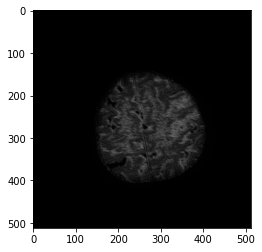

In [173]:
plt.imshow(test_preds[1], cmap='gray')

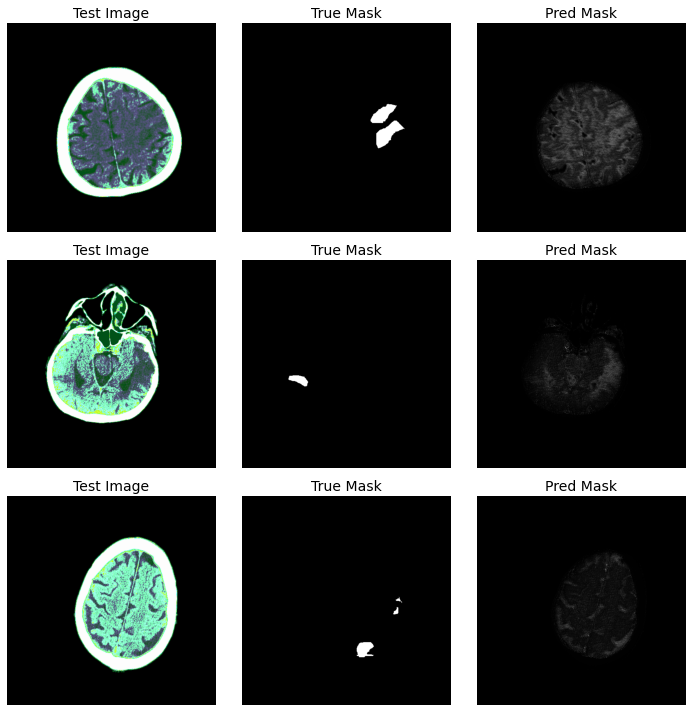

In [174]:
# set up the canvas for the subplots
plt.figure(figsize=(10,10))
plt.axis('Off')

# Our subplot will contain 3 rows and 3 columns
# plt.subplot(nrows, ncols, plot_number)


# == row 1 ==

# image
plt.subplot(3,3,1)
test_image = kucukX_test[1]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,2)
mask = kucukY_test[1]
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,3)
test_mask = test_preds[1]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')


# == row 2 ==

# image
plt.subplot(3,3,4)
test_image = kucukX_test[2]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,5)
mask = kucukY_test[2]
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,6)
test_mask = test_preds[2]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')

# == row 3 ==

# image
plt.subplot(3,3,7)
test_image = kucukX_test[3]
plt.imshow(test_image)
plt.title('Test Image', fontsize=14)
plt.axis('off')


# true mask
plt.subplot(3,3,8)
mask = mask = kucukY_test[3]
plt.imshow(mask, cmap='gray')
plt.title('True Mask', fontsize=14)
plt.axis('off')

# predicted mask
plt.subplot(3,3,9)
test_mask = test_preds[3]
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')


plt.tight_layout()
plt.show()